This is a short code with the objective to better understand the main issues and produce a meaningfull score ( 0.3740 on LB - top 8%). I benefited from reading several of the more detailed kernels (eg beluga, and adapted some of the code) but wanted to have something easier using Light GBM.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import lightgbm as lgb
import gc

myfolder = '../input/'
print('loading files...')
train = pd.read_csv(myfolder+'train.csv')
test = pd.read_csv(myfolder+'test.csv')
print(train.shape, test.shape)

#remove outliers  (about an hour and half max to go to JFK )
train = train[train['trip_duration'] <  train['trip_duration'].quantile(0.999)]
train = train[train['trip_duration'] <= train['trip_duration'].mean() + 3*train['trip_duration'].std()]
print(' max time in min {:.2f} and mean time in sec {:.2f} '.format(
    train['trip_duration'].max()/60, train['trip_duration'].mean()))

# NYC longitude and latitude borders 
ep = 0.0001      
(lng1,lng2)=(-74.257*(1+ep), -73.699*(1-ep))
(lat1,lat2)=(40.495*(1+ep), 40.915*(1-ep)) 
train = train[(train['pickup_longitude'] <=lng2)&(train['pickup_longitude'] >=lng1)]
train = train[(train['pickup_latitude'] <=lat2) & (train['pickup_latitude'] >=lat1)]
train = train[(train['dropoff_longitude'] <=lng2)&(train['dropoff_longitude'] >=lng1)]
train = train[(train['dropoff_latitude'] <=lat2)&(train['dropoff_latitude'] >=lat1)]

#  combine train and test into a single frame
train['eval_set'] = 1
test['eval_set'] = 2
Data = pd.concat([train, test], axis=0)
print(train.shape,test.shape,len(test)+len(train),Data.shape)

del train, test
gc.collect()
Data.head(2)

loading files...
(1458644, 11) (625134, 9)
 max time in min 98.70 and mean time in sec 834.70 
(1454702, 12) (625134, 10) 2079836 (2079836, 12)


,dropoff_datetime,dropoff_latitude,dropoff_longitude,eval_set,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id
0,2016-03-14 17:32:30,40.765602,-73.964630,1,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,455.0,2
1,2016-06-12 00:54:38,40.731152,-73.999481,1,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,663.0,1


In [2]:
# transform the time variables, combine hours and minutes and add holidays
Data['log_trip_duration'] = np.log(Data['trip_duration'].values + 1)
Data['pickup_datetime'] = pd.to_datetime(Data.pickup_datetime)
Data['Month'] = Data['pickup_datetime'].dt.month
Data['DayofMonth'] = Data['pickup_datetime'].dt.day
Data['Timehm'] =Data['pickup_datetime'].dt.hour+Data['pickup_datetime'].dt.minute/60.
Data['dayofweek'] = Data['pickup_datetime'].dt.dayofweek
holidays = calendar().holidays(start='2015-12-31', end='2016-07-01')
Data['Holiday']=Data['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays).astype(int)
Data.drop(['trip_duration','dropoff_datetime','pickup_datetime'], axis=1,inplace=True)
# and replace the N,Y with 0,1
Data['store_and_fwd_flag'] = Data['store_and_fwd_flag'].map({'N': 0, 'Y':1}).astype(int)
Data.shape

(2079836, 15)

In [3]:
# calculate the distance and direction between pickup and dropooff coordinates

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    d = np.sin(lat2/2-lat1/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng2/2-lng1/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(d))   # 6,371 km is the earth radius

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    return haversine_array(lat1,lng1,lat1,lng2)+haversine_array(lat1,lng1,lat2,lng1)

def bearing_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng2 - lng1) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng2 - lng1)
    return np.degrees(np.arctan2(y, x))

Data['distance_haversine'] = haversine_array(Data['pickup_latitude'].values, Data['pickup_longitude'].values, 
                                          Data['dropoff_latitude'].values, Data['dropoff_longitude'].values)
Data['distance_dummy_manhattan'] =  dummy_manhattan_distance(Data['pickup_latitude'].values, 
            Data['pickup_longitude'].values, Data['dropoff_latitude'].values, Data['dropoff_longitude'].values)
Data['direction'] = bearing_array(Data['pickup_latitude'].values, Data['pickup_longitude'].values, 
                                      Data['dropoff_latitude'].values, Data['dropoff_longitude'].values)
Data.shape

(2079836, 18)

In [4]:
#  replace latitudes and longitudes with 81 clusters

coords = np.vstack((Data[['pickup_latitude', 'pickup_longitude']].values,
                    Data[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=9**2, batch_size=36**3).fit(coords[sample_ind])
Data['pickup_cluster'] = kmeans.predict(Data[['pickup_latitude', 'pickup_longitude']])
Data['dropoff_cluster'] = kmeans.predict(Data[['dropoff_latitude', 'dropoff_longitude']])
Data.shape

(2079836, 20)

In [5]:
pca = PCA().fit(coords)
Data['pickup_pca0'] = pca.transform(Data[['pickup_latitude', 'pickup_longitude']])[:, 0]
Data['pickup_pca1'] = pca.transform(Data[['pickup_latitude', 'pickup_longitude']])[:, 1]
Data['dropoff_pca0'] = pca.transform(Data[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
Data['dropoff_pca1'] = pca.transform(Data[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
Data['pca_manhattan'] = np.abs(Data['dropoff_pca1']-Data['pickup_pca1']) +  np.abs(
                                 Data['dropoff_pca0']-Data['pickup_pca0'])
Data['center_latitude'] = 0.5*Data['pickup_latitude']+0.5*Data['dropoff_latitude']
Data['center_longitude'] = 0.5*Data['pickup_longitude']+0.5*Data['dropoff_longitude']
del coords, sample_ind, kmeans
Data.shape

(2079836, 27)

In [6]:
# optional external data (OSRM features) from Oscarleo
# https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/data

flag=False
if flag:
    cols=['id', 'total_distance', 'total_travel_time',  'number_of_steps']
    fr1 = pd.read_csv(myfolder+'fastest_routes_train_part_1.csv', usecols=cols)
    fr2 = pd.read_csv(myfolder+'fastest_routes_train_part_2.csv', usecols=cols)
    fr3 = pd.read_csv(myfolder+'fastest_routes_test.csv', usecols=cols)
    tmp = pd.concat((fr1, fr2, fr3))
    tmp.columns=['id', 'OSRM_distance', 'OSRM_time',  'OSRM_steps']
    Data = Data.merge(tmp, how='left', on='id')
    del fr1, fr2, fr3, tmp
    gc.collect()
    Data.shape
print(flag)  

False


In [7]:
# split the data set back to train and test (for submission) and the train into "train" and "eval" sets for ML
# save the ids for future

Test_id = Data['id'].loc[Data['eval_set']==2].to_frame()
Data.drop('id',axis = 1, inplace=True)
train = Data[Data['eval_set'] == 1]
test = Data[Data['eval_set'] == 2]
print(Data.shape, train.shape, test.shape)

X=train.drop(['eval_set','log_trip_duration'],axis=1)
y=train['log_trip_duration']
features=list(X.columns)
cfeatures = list(X.select_dtypes(include = ['int64','int32']).columns)

X_train, X_eval, y_train, y_eval = train_test_split(X,y, test_size=0.2, random_state=2)

del train, Data
gc.collect()

(2079836, 26) (1454702, 26) (625134, 26)


58

In [8]:
print('formatting and training LightGBM regression ...')
# use higher num_boost_round eg 1000

lgb_train = lgb.Dataset(X_train.values, y_train.values)
lgb_eval = lgb.Dataset(X_eval.values, y_eval.values, reference = lgb_train)
params = {'metric': 'rmse', 'learning_rate' : 0.05, 'num_leaves': 512, 
         'feature_fraction': 0.9,'bagging_fraction':0.9,'bagging_freq':5,'min_data_in_leaf': 500}
lgb_model = lgb.train(params, lgb_train, num_boost_round = 200, valid_sets = lgb_eval, 
             feature_name=features, early_stopping_rounds=10,  verbose_eval = 10)

del lgb_train
gc.collect()

formatting and training LightGBM regression ...
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's rmse: 0.559066
[20]	valid_0's rmse: 0.453798
[30]	valid_0's rmse: 0.403444
[40]	valid_0's rmse: 0.379056
[50]	valid_0's rmse: 0.366578
[60]	valid_0's rmse: 0.359202
[70]	valid_0's rmse: 0.354407
[80]	valid_0's rmse: 0.350908
[90]	valid_0's rmse: 0.348347
[100]	valid_0's rmse: 0.345998
[110]	valid_0's rmse: 0.344345
[120]	valid_0's rmse: 0.342637
[130]	valid_0's rmse: 0.341164
[140]	valid_0's rmse: 0.339905
[150]	valid_0's rmse: 0.338526
[160]	valid_0's rmse: 0.337578
[170]	valid_0's rmse: 0.336386
[180]	valid_0's rmse: 0.335296
[190]	valid_0's rmse: 0.33448
[200]	valid_0's rmse: 0.333554


41

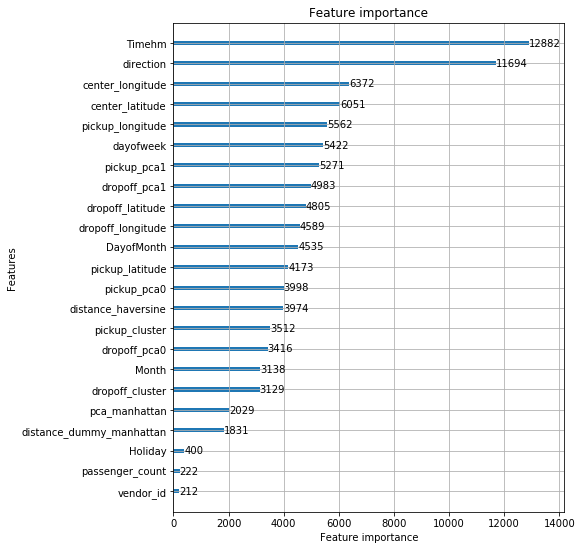

In [9]:
#check feature importance
lgb.plot_importance(lgb_model,  max_num_features=28, figsize=(7,9))
plt.show()

In [10]:
pred = lgb_model.predict(test.drop(['eval_set','log_trip_duration'], axis=1).values, 
                         num_iteration = lgb_model.best_iteration)
Test_id['trip_duration']=np.maximum(0,np.exp(pred) - 1)
Test_id.to_csv('submission.csv', index=False)
print(Test_id['trip_duration'].mean())           # just a sanity check - it should be around 806

801.5501558966741


In [11]:
#check the score again
pred1 = lgb_model.predict(X_train.values, num_iteration = lgb_model.best_iteration)
pred2 = lgb_model.predict(X_eval.values, num_iteration = lgb_model.best_iteration)
rmsle1= (((y_train-pred1)**2).mean())**0.5
rmsle2 = (((y_eval-pred2)**2).mean())**0.5
print('train score: {:.4f}   eval score: {:.4f}'.format(rmsle1,rmsle2))

train score: 0.3224   eval score: 0.3336
